# Modeling and Conclusions

In the previous notebooks, we have cleaned, preprocessed and conducted EDA on our data. Now we will proceed to model our data using `LogisticRegression`, `NaiveBayes`, and `RandomForest`.

We will be carrying out the following steps:

1. [Stop Words Removal](#Stop-Words-Removal)
2. [Getting our data reading for modeling](#Getting-our-data-ready-for-modeling)
3. [Benchmark Model Score](#Benchmark-Model-Score)
4. [Model Testing](#Model-Testing)
    - [Logistic Regression](#Logistic-Regression)<br>
    - [Multinomial Naive Bayes](#Naive-Bayes)<br>
    - [Random Forest](#Random-Forest)<br>
5. [Tuning Models](#Tuning-Models)
6. [Further Tuning](#Further-Tuning)
7. [Error Analysis](#Error-Analysis)
8. [Rerun Modeling](#Rerun-Modeling)
9. [Model Limitations](#Model-Limitations)

This is the fourth of four notebooks:
1. [Subreddit Scraping](1_Subreddit_Scraping.ipynb)
2. [Data Cleaning](2_Data_Cleaning.ipynb)
3. [EDA on Cleaned Subreddits Data](3_EDA_on_Subreddits.ipynb)
4. **Modeling and Conclusions (Current Notebook)**

# Imports

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, \
                            accuracy_score, precision_score, \
                            recall_score, make_scorer

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import MultinomialNB

> Reading in the 2 subreddits data.

In [5]:
# cleaned data from r/keto
keto = pd.read_csv('datasets/keto_cleaned.csv')

# cleaned data from r/zerocarb
zerocarb = pd.read_csv('datasets/zerocarb_cleaned.csv')

# Stop Words Removal

The very first step that we will take will be to remove stop words. These are words that will cause bias in our model, and we want to get rid of those words within reason. In addition to using the stop words in the CountVectorizer library and the TFID library, we will also add in those words that will indicate the subreddit the text is from strongly, e.g. 'Keto', 'Zero', 'Carb', etc.

We will take a look at some of the most common words that occur within our 2 dataframes, and use those to compile a list of stop words. This will be an iterative process. We will use count vectorizer to help with this.

In [542]:
custom_stop_words = list(CountVectorizer(stop_words='english').get_stop_words())

In [543]:
def get_top_words(data, col, 
                  num_of_words=30, 
                  stop_words=[], 
                  n_gram=()):
    
    """Accepts input of DataFrame, string column name, 
    number of words, existing stop words list, n_gram."""
    
    # defining variable
    stop_words = stop_words
    
    # check variable length and define vectorizer 
    # based on if statements
    if len(stop_words) and len(n_gram):
        cvec = CountVectorizer(stop_words=stop_words,
                              ngram_range=(n_gram))
    elif len(stop_words):
        cvec = CountVectorizer(stop_words=stop_words)
    elif len(n_gram):
        cvec = CountVectorizer(ngram_range=(n_gram))
    else:
        cvec = CountVectorizer()
        
    # Vectorize our column        
    X = data[col]
    X_cvec = cvec.fit_transform(X)

    # temp DataFrame for sake of creating top words
    df = pd.DataFrame(X_cvec.todense(),
                       columns=cvec.get_feature_names_out())
    
    # return the top n words
    return df.sum().sort_values(ascending=False).head(num_of_words)
    

#### Run 1

In [544]:
get_top_words(keto, 'c_text', 30, custom_stop_words).index

Index(['keto', 'just', 'weight', 'im', 'like', 'carbs', 'day', 'diet', 'eat',
       'time', 'eating', 've', 'fat', 'know', 'feel', 'really', 'started',
       'doing', 'ive', 'week', 'days', 'lost', 'want', 'carb', 'good',
       'protein', 'food', 'months', 'calories', 'weeks'],
      dtype='object')

In [545]:
get_top_words(zerocarb, 'c_text', 30, custom_stop_words).index

Index(['just', 'meat', 'diet', 'like', 'eat', 'eating', 'fat', 'beef', 've',
       'day', 'carnivore', 'zc', 'feel', 'carb', 'know', 'time', 'im',
       'really', 'days', 'zero', 'good', 'don', 'people', 'weight', 'food',
       'keto', 'way', 'think', 'want', 'week'],
      dtype='object')

In [546]:
get_top_words(keto, 'c_text', 30, custom_stop_words, (2,2)).index

Index(['keto diet', 'weight loss', 'doing keto', 'started keto', 'low carb',
       'net carbs', 'feel like', 'lose weight', 'losing weight', 'blood sugar',
       'years ago', 'carbs day', 'keto months', 'weeks ago',
       'intermittent fasting', 'water weight', 'goal weight', 'calories day',
       'keto flu', 'keto weeks', 'keto friendly', 'don want', 'start keto',
       'don know', 'keto years', 'starting keto', 'blood pressure', 've keto',
       'did keto', 'dont know'],
      dtype='object')

In [547]:
get_top_words(zerocarb, 'c_text', 30, custom_stop_words, (2,2)).index

Index(['zero carb', 'ground beef', 'carnivore diet', 'feel like',
       'weight loss', 'grass fed', 'low carb', 'don know', 'eating meat',
       'red meat', 'way eating', 'eat meat', 'bone broth', 'carb diet',
       'lose weight', 'don want', 'years ago', 'long time', '30 days',
       'body fat', 'beef liver', 'just wondering', 'days ago', 'just eat',
       'feel better', 'gt gt', 'hey guys', 've eating', 've tried',
       've doing'],
      dtype='object')

Looking at the list above, we will add the following words to our custom stop word list:
> 'keto', 'meat', 'carnivore', 'zero', 'carb', 'carbs', 'zerocarb'

After error analysis of our model, we also added in the following: 'ketosis'

In [548]:
custom_stop_words += ['keto', 'meat', 'carnivore', 'zero', 'carb', 'carbs', 'zerocarb', 'ketosis']

#### Run 2

In [549]:
get_top_words(keto, 'c_text', 30, custom_stop_words).index

Index(['just', 'weight', 'im', 'like', 'day', 'diet', 'eat', 'time', 'eating',
       've', 'fat', 'know', 'feel', 'really', 'started', 'doing', 'ive',
       'week', 'days', 'lost', 'want', 'good', 'protein', 'food', 'months',
       'calories', 'weeks', 'sugar', 'going', 'don'],
      dtype='object')

In [550]:
get_top_words(zerocarb, 'c_text', 30, custom_stop_words).index

Index(['just', 'diet', 'like', 'eat', 'eating', 'fat', 'beef', 've', 'day',
       'zc', 'feel', 'know', 'time', 'im', 'really', 'days', 'good', 'don',
       'people', 'weight', 'food', 'way', 'think', 'want', 'week', 'going',
       'eggs', 'water', 'started', 'lot'],
      dtype='object')

Looking at the list above, we will add the following words to our custom stop word list:
> 'zc', 'beef', 'eggs', 'sugar'

In [551]:
custom_stop_words += ['zc', 'beef', 'eggs', 'sugar']

Now we will do one last check on bigrams to see if we can get any further insight into words we should remove from our model.

In [552]:
get_top_words(keto, 'c_text', 30, custom_stop_words, (2,2)).index

Index(['weight loss', 'feel like', 'lose weight', 'losing weight', 'years ago',
       'weeks ago', 'intermittent fasting', 'water weight', 'goal weight',
       'calories day', 'don want', 'don know', 'blood pressure', 'dont know',
       'make sure', 'thanks advance', 'days week', 'lost weight', 'body fat',
       'im just', 've doing', 'ive lost', 'feel better', 'just wanted',
       'dont want', 'long term', 'ice cream', 'days ago', 've lost',
       'months ago'],
      dtype='object')

In [553]:
get_top_words(zerocarb, 'c_text', 30, custom_stop_words, (2,2)).index

Index(['feel like', 'weight loss', 'grass fed', 'don know', 'way eating',
       'bone broth', 'lose weight', 'don want', 'years ago', 'long time',
       '30 days', 'body fat', 'just wondering', 'days ago', 'gt gt',
       'just eat', 'feel better', 'hey guys', 've eating', 've tried',
       've doing', 'salt water', 'little bit', 'high fat', 'organ meats',
       'thanks advance', 'felt like', 'heavy cream', 'months ago',
       'feel great'],
      dtype='object')

From the above, we can see that there are quite a few words more that we should add into our `custom_stop_words` list. Let's do that now.
> 'intermittent', 'fasting', 'blood', 'pressure', 'ice', 'cream', 'bone', 'broth', 'organ', 'meats', 'heavy', 'cream', 'gt'

In [554]:
custom_stop_words += ['intermittent', 'fasting', 'blood', 'pressure', 
                      'ice', 'cream', 'bone', 'broth', 'organ', 'meats', 
                      'heavy', 'cream', 'gt']

#### Run 3

In [555]:
get_top_words(keto, 'c_text', 30, custom_stop_words, (2,2)).index

Index(['weight loss', 'feel like', 'lose weight', 'losing weight', 'years ago',
       'weeks ago', 'water weight', 'goal weight', 'calories day', 'don want',
       'don know', 'dont know', 'make sure', 'thanks advance', 'days week',
       'lost weight', 'body fat', 'im just', 've doing', 'ive lost',
       'feel better', 'just wanted', 'dont want', 'long term', 'days ago',
       've lost', 'months ago', 'long time', 'just want', 'im doing'],
      dtype='object')

In [556]:
get_top_words(zerocarb, 'c_text', 30, custom_stop_words, (2,2)).index

Index(['feel like', 'weight loss', 'grass fed', 'don know', 'way eating',
       'lose weight', 'don want', 'years ago', 'long time', '30 days',
       'body fat', 'just wondering', 'days ago', 'just eat', 'feel better',
       'hey guys', 've eating', 've tried', 've doing', 'salt water',
       'little bit', 'high fat', 'thanks advance', 'felt like', 'months ago',
       'feel great', 'long term', 'brain fog', 'weeks ago', 'just curious'],
      dtype='object')

In [557]:
custom_stop_words = pd.DataFrame(custom_stop_words, columns=['words'])
custom_stop_words.to_csv('datasets/custom_stop_words.csv', index=False)

Now we have our stop words list and we are ready to use it in our modeling.

---

# Getting our data ready for modeling

In order to start modeling on our dataset, we will need to merge our two different dataframes into 1 dataframe to feed into our model.

In [559]:
# concat our 2 datasets
df = pd.concat([keto, zerocarb], ignore_index=True)

After merging the two dataframes, we should be left with a new dataframe with 14 columns. Let's check this now.

In [23]:
df.shape

(19669, 14)

Next we will adjust the values in the `subreddit` column to take 1s and 0s. <br>
1 will denote `r/keto`, and 0 will denote `r/zerocarb`.

In [24]:
# check ratio of 'r/keot' vs 'r/zerocarb' before mapping
df['subreddit'].value_counts(normalize=True)

keto        0.5015
zerocarb    0.4985
Name: subreddit, dtype: float64

In [25]:
# map 1 if keto and 0 if not keto (i.e. 0 if zerocarb)
df['subreddit'] = df['subreddit'].map(
                                    lambda x: 1 if x == 'zerocarb'
                                    else 0)

In [26]:
# sanity check to ensure mapping is done correctly
df['subreddit'].value_counts(normalize=True)

0    0.5015
1    0.4985
Name: subreddit, dtype: float64

In [28]:
# rename 'subreddit' column to make model evaluation later easier
df.rename(columns={'subreddit': 'is_zerocarb'}, inplace=True)

In [30]:
# dropping unecessary columns to make our merged DataFrame lighter
df.drop(columns=['num_comments', 'score', 'upvote_ratio',
                 'subreddit_subscribers', 'subreddit_type', 
                 'total_awards_received', 'whitelist_status',
                 'month_year'], inplace=True)

In [32]:
df.to_csv('datasets/merged_for_modeling.csv', index=False)

With a custom list of stop words, and our merged dataset, we are now ready to begin modeling. In terms of re-running models when we come back to this notebook in the future, we would be able to skip all the above steps, and just read in the merged DataFrame and simply begin modeling from there.

# Benchmark Model Score

We will build a simple Multinomial Naive Bayes model, with the CountVectorizer, with removal of our `custom_stop_words` list to get our baseline score that we will measure our other models against.

In [351]:
# re-read in our merged DataFrame and custom_stop_words
df = pd.read_csv('datasets/merged_for_modeling.csv')

custom_stop_words = pd.read_csv('datasets/custom_stop_words.csv')
custom_stop_words = custom_stop_words['words'].tolist()

In [55]:
# getting train_test_split for our baseline model
# this train_test_split will be used for ALL our models
X = df['c_text']
y = df['is_zerocarb']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [81]:
# creating pipeline for baseline model
pipe_baseline = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=custom_stop_words)),
    ('nb', MultinomialNB())]
)

In [86]:
# fitting our model
pipe_baseline.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(stop_words=['amoungst', 'rather', 'everyone',
                                             'either', 'upon', 'which',
                                             'amount', 'when', 'least', 'from',
                                             'mostly', 'thereby', 'nobody',
                                             'inc', 'still', 'has', 'twelve',
                                             'were', 'about', 'between',
                                             'formerly', 'through', 'put',
                                             'with', 'ours', 'take', 'himself',
                                             'often', 'thereafter', 'can', ...])),
                ('nb', MultinomialNB())])

In [88]:
# training score
pipe_baseline.score(X_train, y_train)

0.8856053384175405

In [87]:
# testing score
pipe_baseline.score(X_test, y_test)

0.8274021352313167

In [85]:
# baseline predictions to create confusion matrix
bm_predictions = pipe_baseline.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, bm_predictions).ravel()

print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')

True Negatives: 1756
False Positives: 217
False Negatives: 462
True Positives: 1499


We now have a baseline score of **82.7%** which we will measure our other models against, and attempt to create the best model via fine tuning our hyper parameters and other adjustments to the model.

As a side note, we can see that our baseline model is definitely overfit as the score on our training data is **89%**, however the score on our test data is **83%**. We will attempt to address this as we select the best models and we tune our models.

# Model Testing

For this section of the notebook, we will be mainly focusing on three model types:<br>
*each model will use random_state 42(where possible), so that we can repeat the model performance which makes for easier comparison*

[1. Logistic Regression](#Logistic-Regression)<br>
[2. Multinomial Naive Bayes](#Naive-Bayes)<br>
[3. Random Forest Trees](#Random_Forest_Trees)<br>

For each of them, we will attempt to get the best possible model performance by tuning the model, and at the end will will compare the best model from each type. Following which we will attempt further tuning if possible.

For this section, we opted to creat a custom function that will fit our model, and add the results to a list, which we can view and compare across different models. For this function, we will instatiate all our vectorizers, models, and parameters which can be tuned.

In [414]:
# Instantiate vectorizers
vectorizers = {'cvec': CountVectorizer(stop_words=custom_stop_words),
               'tvec': TfidfVectorizer(stop_words=custom_stop_words)}

In [415]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=1_000, random_state=42),
          'nb': MultinomialNB(),
          'rf': RandomForestClassifier(random_state=42),
}

In [353]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1'],

     # Trying different C of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[0.1, 1, 10, 11]
}

nb_params = { 
    # Trying different fit priors
    'nb__fit_prior': [True, False],
    
    # Trying different types of alpha
    'nb__alpha': [0, 0.4, 0.8]
}

rf_params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
    'rf__max_features': ['sqrt', 'log2', 0.5]
}

In [354]:
cvec_params = {
    # Setting a limit of n-number of features included
    'cvec__max_features': [None, 10_000],

    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'cvec__min_df':[2, 3, 4],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus 
    'cvec__max_df': [0.4, 0.5, 0.8],
    
    # Testing with ngrams
    'cvec__ngram_range':[(1,1), (1,2)]
}

tvec_params = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None, 10_000],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[2, 3, 4],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.4, 0.5, 0.8],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1,1), (1,2)]
}

In [561]:
# Function to run model -- input vectorizer and model
def get_model_scores(model_name, 
                     vec, 
                     mod, 
                     vec_params={}, 
                     mod_params={}, 
                     grid_search=False):
    
    """Function accepts following inputs:
    Name of model (str), vectorizer to be used (str), 
    model to be used (str), vectorizer params(dict, optional), 
    model params(dict, optional), grid_seach(boolean, optional)
    If grid_search is True, then please also input the relevant 
    params for GridSearching
    """
    
    # empty dict for appending results
    results = {}
    
    # instantiate pipe
    pipe = Pipeline([
            (vec, vectorizers[vec]),
            (mod, models[mod])
            ])
    
    # check if GridSearch true or false
    if grid_search:
        
        # combine vectorizer and mod params together
        gs_params = {}
        gs_params.update(vec_params)
        gs_params.update(mod_params)
        
        # instantiate GridSearchCV
        gs = GridSearchCV(pipe, 
                          param_grid=gs_params,
                          cv=5, 
                          verbose=2, 
                          n_jobs=-2)
        
        # fit model
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        # else fit model
        pipe.fit(X_train, y_train)
    
    # create predictions and confusion matrix
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    # Retrieve metrics and add to results
    results['model_name'] = model_name
    results['model'] = mod
    results['vectorizer'] = vec
    results['train_score'] = pipe.score(X_train, y_train)
    results['test_score'] = pipe.score(X_test, y_test)
    
    results['recall'] = recall_score(y_test, 
                                     predictions)
    
    results['true_neg_rate'] = tn/(tn+fp)
    
    results['precision'] = precision_score(y_test, 
                                           predictions)
    results['is_tuned'] = grid_search
    
    if grid_search:
        print('BEST PARAMS-->')
        display(pipe.best_params_)
    
    # add results to list for model evaluation later
    model_eval.append(results)
    
    print('METRICS-->')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [75]:
# creating list to store the model scores.
model_eval = []

## Logistic Regression

We will be testing both CountVectorizer and TfidfVectorizer for each model, without any tuning of hyper parameters.

In [76]:
cvec_lr = get_model_scores('cvec_lr', 
                           'cvec', 
                           'lr')

METRICS-->


{'model_name': 'cvec_lr',
 'model': 'lr',
 'vectorizer': 'cvec',
 'train_score': 0.9883063234826819,
 'test_score': 0.8362989323843416,
 'recall': 0.8449770525242223,
 'true_neg_rate': 0.8276735935124176,
 'precision': 0.829744616925388,
 'is_tuned': False}

True Negatives: 1633
False Positives: 340
False Negatives: 304
True Positives: 1657


In [77]:
tvec_lr = get_model_scores('tvec_lr',
                           'tvec', 
                           'lr')

METRICS-->


{'model_name': 'tvec_lr',
 'model': 'lr',
 'vectorizer': 'tvec',
 'train_score': 0.9103908484270734,
 'test_score': 0.8474834773767158,
 'recall': 0.8342682304946456,
 'true_neg_rate': 0.8606183476938672,
 'precision': 0.8560962846677133,
 'is_tuned': False}

True Negatives: 1698
False Positives: 275
False Negatives: 325
True Positives: 1636


Without any sort of tuning, we can see that the `TfidfVectorizer` has improved our score from the baseline score of **83.6%**, to now **84.7%**. Let's now take a look at Naive Bayes.

## Naive Bayes

In [78]:
cvec_nb = get_model_scores('cvec_nb',
                           'cvec', 
                           'nb')

METRICS-->


{'model_name': 'cvec_nb',
 'model': 'nb',
 'vectorizer': 'cvec',
 'train_score': 0.8955830950111217,
 'test_score': 0.8304524656837824,
 'recall': 0.8077511473737888,
 'true_neg_rate': 0.8530157121135327,
 'precision': 0.8452508004268944,
 'is_tuned': False}

True Negatives: 1683
False Positives: 290
False Negatives: 377
True Positives: 1584


In [211]:
tvec_nb = get_model_scores('tvec_nb', 
                           'tvec', 
                           'nb')

METRICS-->


{'model_name': 'tvec_nb',
 'model': 'nb',
 'vectorizer': 'tvec',
 'train_score': 0.8856053384175405,
 'test_score': 0.8274021352313167,
 'recall': 0.7644059153493116,
 'true_neg_rate': 0.8900152052711606,
 'precision': 0.8735431235431236,
 'is_tuned': False}

True Negatives: 1756
False Positives: 217
False Negatives: 462
True Positives: 1499


In the case of Naive Bayes, it turns out that the `CountVectorizer` led to a better performance, however this performs below our base model.

---

## Random Forest

In [90]:
cvec_rf = get_model_scores('cvec_rf', 
                           'cvec', 
                           'rf')

METRICS-->


{'model_name': 'cvec_rf',
 'model': 'rf',
 'vectorizer': 'cvec',
 'train_score': 1.0,
 'test_score': 0.8256227758007118,
 'recall': 0.815910249872514,
 'true_neg_rate': 0.8352762290927521,
 'precision': 0.8311688311688312,
 'is_tuned': False}

True Negatives: 1648
False Positives: 325
False Negatives: 361
True Positives: 1600


In [91]:
tvec_rf = get_model_scores('tvec_rf', 
                           'tvec', 
                           'rf')

METRICS-->


{'model_name': 'tvec_rf',
 'model': 'rf',
 'vectorizer': 'tvec',
 'train_score': 1.0,
 'test_score': 0.8274021352313167,
 'recall': 0.8052014278429372,
 'true_neg_rate': 0.8494678155093766,
 'precision': 0.841684434968017,
 'is_tuned': False}

True Negatives: 1676
False Positives: 297
False Negatives: 382
True Positives: 1579


Now let's take a look at tuning our best performing models. Based on the above, we will tune `LogisticRegression` with `TfidfVectorizer`, as well as `NaiveBayes` with `CountVectorizer`, and `TfidfVectorizer`, and `RandomForest` with `TfidfVectorizer`. <br>
This is based on the `accuracy` scores as well as the `precision` scores, of which `precision` is the most relevant to our problem statment.

# Tuning Models

At a later part of the notebook, during error analysis, we realized that there was a critical stop word that had not been removed, so we removed that, and refit the base models, as well as did tuning to get our final model again, so please take these models here with a grain of salt.

In [94]:
tvec_lr_gs = get_model_scores('tvec_lr_gs', 
                              'tvec', 
                              'lr', 
                              vec_params=tvec_params, 
                              mod_params=lr_params, 
                              grid_search=True)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
720 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
  

BEST PARAMS-->


{'lr__C': 10,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.4,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_lr_gs',
 'model': 'lr',
 'vectorizer': 'tvec',
 'train_score': 0.9971401334604385,
 'test_score': 0.8472292831723437,
 'recall': 0.8291687914329424,
 'true_neg_rate': 0.8651799290420679,
 'precision': 0.8594080338266384,
 'is_tuned': True}

True Negatives: 1707
False Positives: 266
False Negatives: 335
True Positives: 1626


We saw a 0.3% improvement in the `precision` score, however there was a drop in the `accuracy` score.

In [98]:
cvec_nb_gs = get_model_scores('cvec_nb_gs', 
                              'cvec', 
                              'nb', 
                              vec_params=cvec_params, 
                              mod_params=nb_params, 
                              grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
BEST PARAMS-->


{'cvec__max_df': 0.4,
 'cvec__max_features': None,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.8,
 'nb__fit_prior': True}

METRICS-->


{'model_name': 'cvec_nb_gs',
 'model': 'nb',
 'vectorizer': 'cvec',
 'train_score': 0.9220845249443915,
 'test_score': 0.8396034570411794,
 'recall': 0.842937276899541,
 'true_neg_rate': 0.8362899138367967,
 'precision': 0.8365384615384616,
 'is_tuned': True}

True Negatives: 1650
False Positives: 323
False Negatives: 308
True Positives: 1653


In [119]:
tvec_nb_gs = get_model_scores('tvec_nb_gs', 
                              'tvec', 
                              'nb', 
                              vec_params=tvec_params, 
                              mod_params=nb_params, 
                              grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
BEST PARAMS-->


{'nb__alpha': 0.4,
 'nb__fit_prior': False,
 'tvec__max_df': 0.4,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_nb_gs',
 'model': 'nb',
 'vectorizer': 'tvec',
 'train_score': 0.921258341277407,
 'test_score': 0.8383324860193188,
 'recall': 0.8291687914329424,
 'true_neg_rate': 0.8474404460212874,
 'precision': 0.843798650752465,
 'is_tuned': True}

True Negatives: 1672
False Positives: 301
False Negatives: 335
True Positives: 1626


For the `cvec` and `NaiveBayes` model, we saw a deprovement in `precision` score and an improvement in `accuracy` score. For the `tvec` and `NaiveBayes` model, we saw a larger drop in `precision` score and a drop in `accuracy` as well.
For this reason we will most likely pick the `LogisticRegression` model. However we will still attempt fine tuning of this model.

---

For our `RandomForest` model, running it via `GridsearchCV` will take quite some time, as such we will opt to use `RandomSearchCV` instead. Since we have already written a function previously, we will just rewrite the function and replace `GridSearchCV` with `RandomSearchCV` instead.

In [191]:
# Function to run model, exactly same as before, 
# only with randomized search
def get_model_scores_rfe(model_name, 
                         vec, 
                         mod, 
                         vec_params={}, 
                         mod_params={}, 
                         random_search=False):
    
    results = {}
    
    pipe = Pipeline([
            (vec, vectorizers[vec]),
            (mod, models[mod])
            ])
    
    if random_search:
        rs_params = {}
        rs_params.update(vec_params)
        rs_params.update(mod_params)
        
        rs = RandomizedSearchCV(pipe, 
                                param_distributions=rs_params, 
                                cv=5, 
                                verbose=2, 
                                n_jobs=-2)
        
        rs.fit(X_train, y_train)
        pipe = rs
        
    else:
        pipe.fit(X_train, y_train)
    
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    # Retrieve metrics
    results['model_name'] = model_name
    results['model'] = mod
    results['vectorizer'] = vec
    results['train_score'] = pipe.score(X_train, y_train)
    results['test_score'] = pipe.score(X_test, y_test)
    
    results['recall'] = recall_score(y_test, 
                                     predictions)
    
    results['true_neg_rate'] = tn/(tn+fp)
    results['precision'] = precision_score(y_test, 
                                           predictions)
    results['is_tuned'] = random_search
    
    if random_search:
        print('BEST PARAMS-->')
        display(pipe.best_params_)
        
    model_eval.append(results)
    
    print('METRICS-->')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [113]:
tvec_rb_rs = get_model_scores_rfe('tvec_rb_rs', 
                                  'tvec', 
                                  'rf', 
                                  vec_params=tvec_params, 
                                  mod_params=rf_params, 
                                  random_search=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS-->


{'tvec__ngram_range': (1, 2),
 'tvec__min_df': 2,
 'tvec__max_features': 10000,
 'tvec__max_df': 0.4,
 'rf__n_estimators': 300,
 'rf__max_features': 0.5,
 'rf__max_depth': None}

METRICS-->


{'model_name': 'tvec_rb_rs',
 'model': 'rf',
 'vectorizer': 'tvec',
 'train_score': 1.0,
 'test_score': 0.7956278596847992,
 'recall': 0.7582865884752678,
 'true_neg_rate': 0.8327420172326406,
 'precision': 0.8183819482663731,
 'is_tuned': True}

True Negatives: 1643
False Positives: 330
False Negatives: 474
True Positives: 1487


In this case, our `RandomForests` has performed worse on both metrics that we are interested in. In the interest of getting a minimum viable model up and running for 'MyNutritionClinic', we will opt to choose a model that will be quicker to tune and get ready.

In [200]:
model_scoresV1 = pd.DataFrame(model_eval)
model_scoresV1

,model_name,model,vectorizer,train_score,test_score,recall,true_neg_rate,precision,is_tuned
0,cvec_lr,lr,cvec,0.988306,0.836299,0.844977,0.827674,0.829745,False
1,tvec_lr,lr,tvec,0.910391,0.847483,0.834268,0.860618,0.856096,False
2,cvec_nb,nb,cvec,0.895583,0.830452,0.807751,0.853016,0.845251,False
3,tvec_nb,nb,tvec,0.885605,0.827402,0.764406,0.890015,0.873543,False
4,cvec_rf,rf,cvec,1.000000,0.825623,0.815910,0.835276,0.831169,False
5,tvec_rf,rf,tvec,1.000000,0.827402,0.805201,0.849468,0.841684,False
6,tvec_lr_gs,lr,tvec,0.997140,0.847229,0.829169,0.865180,0.859408,True
7,cvec_nb_gs,nb,cvec,0.922085,0.839603,0.842937,0.836290,0.836538,True
8,tvec_rb_rs,rf,tvec,1.000000,0.795628,0.758287,0.832742,0.818382,True
9,tvec_nb_gs,nb,tvec,0.921258,0.838332,0.829169,0.847440,0.843799,True


In [563]:
# evaluating the top 5 models so far by precision score and accuracy score
model_scoresV1.drop(columns=['train_score', 'recall', 'true_neg_rate'])\
.sort_values(by=['precision', 'test_score'], ascending=False).head()

,model_name,model,vectorizer,test_score,precision,is_tuned
3,tvec_nb,nb,tvec,0.827402,0.873543,False
6,tvec_lr_gs,lr,tvec,0.847229,0.859408,True
1,tvec_lr,lr,tvec,0.847483,0.856096,False
2,cvec_nb,nb,cvec,0.830452,0.845251,False
9,tvec_nb_gs,nb,tvec,0.838332,0.843799,True


From the above table, we can see that the base `TfidfVectorizer` with `NaiveBayes` has the best precision performance, but the poorest `accuracy` performance. We can also see that the `LogisticRegression` with `TfidfVectorizer` is not far behind in terms of `precision` however it does about 2% better in terms of `accuracy`. We will conduct further tuning on these two models to choose our final model.

# Further Tuning

First let's adjust the parameters that we will use for `GridSearchCV` in hopes of tuning our model.
We will rewrite the function to add in a scoring parameter that will help us to improve the precision and accuracy score of our model.

This will be a repetitive and iterative process. 

In [326]:
# exact same function as before, 
# just added the line before that is commented on
def get_model_scores_V2(model_name, 
                     vec, 
                     mod, 
                     vec_params={}, 
                     mod_params={}, 
                     grid_search=False):
    
    results = {}
    
    pipe = Pipeline([
            (vec, vectorizers[vec]),
            (mod, models[mod])
            ])
    
    if grid_search:
        gs_params = {}
        gs_params.update(vec_params)
        gs_params.update(mod_params)
        
        # adding in scoring parameters
        scoring = {'Precision': make_scorer(precision_score),
                   'Accuracy': make_scorer(accuracy_score)}
        
        gs = GridSearchCV(pipe, 
                          param_grid=gs_params,
                          scoring=scoring,
                          refit='Accuracy',
                          cv=5, 
                          verbose=2, 
                          n_jobs=-2)
        
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    # Retrieve metrics
    results['model_name'] = model_name
    results['model'] = mod
    results['vectorizer'] = vec
    results['train_score'] = pipe.score(X_train, y_train)
    results['test_score'] = pipe.score(X_test, y_test)
    
    results['recall'] = recall_score(y_test, 
                                     predictions)
    
    results['true_neg_rate'] = tn/(tn+fp)
    
    results['precision'] = precision_score(y_test, 
                                           predictions)
    results['is_tuned'] = grid_search
    
    if grid_search:
        print('BEST PARAMS-->')
        display(pipe.best_params_)
        
    model_eval.append(results)
    
    print('METRICS-->')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

---

We will iterate through different versions of the models and attempt to change the parameters to improve the `precision` and `accuracy` scores.

In [327]:
tvec_nb_gs.best_params_

{'nb__alpha': 0.4,
 'nb__fit_prior': False,
 'tvec__max_df': 0.4,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2)}

In [328]:
# re-adjusting params based on previous run

nb_params_V2 = {   
    # Trying different types of alpha
    'nb__alpha': [0.2, 0.3, 0.4]
}

tvec_nb_params_V2 = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None, 3000, 5000],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[4, 5],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.2, 0.3, 0.4],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1,2), (2,2)]
}

In [329]:
# Let's readjust the parameters based on these results
tvec_nb_gs_V2 = get_model_scores_V2('tvec_nb_gs_V2', 
                                    'tvec', 
                                    'nb', 
                                    vec_params=tvec_nb_params_V2, 
                                    mod_params=nb_params_V2, 
                                    grid_search=True)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
BEST PARAMS-->


{'nb__alpha': 0.4,
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_nb_gs_V2',
 'model': 'nb',
 'vectorizer': 'tvec',
 'train_score': 0.9224022878932316,
 'test_score': 0.838840874428063,
 'recall': 0.827129015808261,
 'true_neg_rate': 0.8504815002534212,
 'precision': 0.8461137193531559,
 'is_tuned': True}

True Negatives: 1678
False Positives: 295
False Negatives: 339
True Positives: 1622


---

In [330]:
# re-adjusting params based on previous run

nb_params_V3 = {   
    # Trying different types of alpha
    'nb__alpha': [0.4, 0.5]
}

tvec_nb_params_V3 = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[3.5, 4, 4.5],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [None, 0.1, 0.2],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1,2), (2,3)]
}

In [331]:
# re-run model with adjusted parameters
tvec_nb_gs_V3 = get_model_scores_V2('tvec_nb_gs_V3', 
                              'tvec', 
                              'nb', 
                              vec_params=tvec_nb_params_V3, 
                              mod_params=nb_params_V3, 
                              grid_search=True)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_tr

BEST PARAMS-->


{'nb__alpha': 0.5,
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_nb_gs_V3',
 'model': 'nb',
 'vectorizer': 'tvec',
 'train_score': 0.9194153161741341,
 'test_score': 0.8383324860193188,
 'recall': 0.8225395206527282,
 'true_neg_rate': 0.8540293968575773,
 'precision': 0.8485007890583903,
 'is_tuned': True}

True Negatives: 1685
False Positives: 288
False Negatives: 348
True Positives: 1613


---

In [370]:
# re-adjusting params based on previous run

nb_params_V4 = {   
    # Trying different types of alpha
    'nb__alpha': [0.5, 0.6, 0.7]
}

tvec_nb_params_V4 = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[4],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.2],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1, 1), (1,2), (1,3)]
}

In [371]:
# re-run model with adjusted parameters
tvec_nb_gs_V4 = get_model_scores_V2('tvec_nb_gs_V4', 
                              'tvec', 
                              'nb', 

                                    vec_params=tvec_nb_params_V4, 
                              mod_params=nb_params_V4, 
                              grid_search=True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
BEST PARAMS-->


{'nb__alpha': 0.5,
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_nb_gs_V4',
 'model': 'nb',
 'vectorizer': 'tvec',
 'train_score': 0.9164918970448046,
 'test_score': 0.8289273004575496,
 'recall': 0.8092809790922999,
 'true_neg_rate': 0.8484541307653319,
 'precision': 0.8414634146341463,
 'is_tuned': True}

True Negatives: 1674
False Positives: 299
False Negatives: 374
True Positives: 1587


We believe that we have pushed this model as far as it can go in terms of balance between `accuracy` and `precision`.
Now we will repeat this process for `LogisticRegression` and then we will take a look at the results again at the end.

---

In [334]:
tvec_lr_gs.best_params_

{'lr__C': 10,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.4,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [372]:
# Re-adjusting parameters from previous run

lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2'],

     # Trying different C of:(C = 1/alpha)
    'lr__C':[9.5, 10, 11]
}

tvec_params = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[1.5, 2, 2.5],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.2, 0.3, 0.4],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1,1), (1,2), (1,3)]
}

In [373]:
tvec_lr_gs_V2 = get_model_scores_V2('tvec_lr_gs_V2', 
                              'tvec', 
                              'lr', 
                              vec_params=tvec_lr_params_V2, 
                              mod_params=lr_params_V2, 
                              grid_search=True)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
BEST PARAMS-->


{'lr__C': 9.5,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_lr_gs_V2',
 'model': 'lr',
 'vectorizer': 'tvec',
 'train_score': 0.9965681601525263,
 'test_score': 0.8439247585155059,
 'recall': 0.8220295767465579,
 'true_neg_rate': 0.8656867714140902,
 'precision': 0.8588172615876398,
 'is_tuned': True}

True Negatives: 1708
False Positives: 265
False Negatives: 349
True Positives: 1612


---

In [388]:
lr_params_V3 = {
    # Trying different types of regularization
    'lr__penalty':['l2'],

     # Trying different C of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[9, 9.25, 9.5]
}

tvec_lr_params_V3 = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[2],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.25, 0.3, 0.35],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1, 1), (1,2), (1,3)]
}

In [389]:
tvec_lr_gs_V3 = get_model_scores_V2('tvec_lr_gs_V3', 
                              'tvec', 
                              'lr', 
                              vec_params=tvec_lr_params_V3, 
                              mod_params=lr_params_V3, 
                              grid_search=True)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
BEST PARAMS-->


{'lr__C': 9,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.35,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_lr_gs_V3',
 'model': 'lr',
 'vectorizer': 'tvec',
 'train_score': 0.9959326342548459,
 'test_score': 0.8439247585155059,
 'recall': 0.8240693523712391,
 'true_neg_rate': 0.863659401926001,
 'precision': 0.8572944297082228,
 'is_tuned': True}

True Negatives: 1704
False Positives: 269
False Negatives: 345
True Positives: 1616


---

In [393]:
lr_params_V4 = {
    # Trying different types of regularization
    'lr__penalty':['l2'],

     # Trying different C of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[11]
}

tvec_lr_params_V4 = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[2],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.35, 0.36, 0.37],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1, 2)]
}

In [394]:
tvec_lr_gs_V4 = get_model_scores_V2('tvec_lr_gs_V4', 
                              'tvec', 
                              'lr', 
                              vec_params=tvec_lr_params_V4, 
                              mod_params=lr_params_V4, 
                              grid_search=True)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
BEST PARAMS-->


{'lr__C': 11,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.35,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_lr_gs_V4',
 'model': 'lr',
 'vectorizer': 'tvec',
 'train_score': 0.998093422306959,
 'test_score': 0.8434163701067615,
 'recall': 0.8225395206527282,
 'true_neg_rate': 0.8641662442980234,
 'precision': 0.8575225943646996,
 'is_tuned': True}

True Negatives: 1705
False Positives: 268
False Negatives: 348
True Positives: 1613


---

In [398]:
lr_params_V5 = {
    # Trying different types of regularization
    'lr__penalty':['l2'],

     # Trying different C of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[5, 6, 7, 8, 9, 10, 11, 12]
}

tvec_lr_params_V5 = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[2],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.3, 0.35, 0.4],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1, 2)]
}

In [399]:
tvec_lr_gs_V5 = get_model_scores_V2('tvec_lr_gs_V5', 
                              'tvec', 
                              'lr', 
                              vec_params=tvec_lr_params_V5, 
                              mod_params=lr_params_V5, 
                              grid_search=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
BEST PARAMS-->


{'lr__C': 5,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.35,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_lr_gs_V5',
 'model': 'lr',
 'vectorizer': 'tvec',
 'train_score': 0.9856371147124245,
 'test_score': 0.8454499237417387,
 'recall': 0.8245792962774094,
 'true_neg_rate': 0.8661936137861125,
 'precision': 0.8596491228070176,
 'is_tuned': True}

True Negatives: 1709
False Positives: 264
False Negatives: 344
True Positives: 1617


We believe that we have pushed this model as far as it can go as well in terms of balance between `accuracy` and `precision`, and maximizing `precision`.
Let's review the results between the different models.

In [400]:
model_scoresV2 = pd.DataFrame(model_eval)
model_scoresV2[model_scoresV2['model_name'].str.contains('V')]\
.sort_values(by=['precision', 'test_score'], ascending=False).head()

,model_name,model,vectorizer,train_score,test_score,recall,true_neg_rate,precision,is_tuned
16,tvec_lr_gs_V5,lr,tvec,0.985637,0.845450,0.824579,0.866194,0.859649,True
13,tvec_lr_gs_V2,lr,tvec,0.996568,0.843925,0.822030,0.865687,0.858817,True
14,tvec_lr_gs_V3,lr,tvec,0.995933,0.843925,0.824069,0.863659,0.857294,True
15,tvec_lr_gs_V4,lr,tvec,0.995234,0.843925,0.824069,0.863659,0.857294,True
11,tvec_nb_gs_V3,nb,tvec,0.919415,0.838332,0.822540,0.854029,0.848501,True


Based on the above model, it seems that the model that performs the best is the following model:
`LogisticRegression` with `TfidfVectorizer` with the following parameters:<br>

**LogisticRegression**
- Penalty Type: `l2`
- Inverse Regularization Strength of `9.9` (`C`)

**TfidfVectorizer**
- `max_df` of `0.4`
- `min_df` of `2`
- `ngram_range` of `(1, 2)`

# Error Analysis

Now we will take a look at some error analysis based on our final model.

In [501]:
# creating dataframe with coefs to obtain top words in our model
coefs = pd.DataFrame(tvec_lr_gs_V5.best_estimator_.steps[1][1].coef_.T, columns=['coef'])
coefs['ngram'] = tvec_lr_gs_V5.best_estimator_.steps[0][1].get_feature_names_out()

# obtaining top words for 'r/keto' and 'r/zerocarb'
top_keto_coefs = coefs.sort_values('coef', ascending=True).head(20)
top_zerocarb_coefs = coefs.sort_values('coef', ascending=True).tail(20)

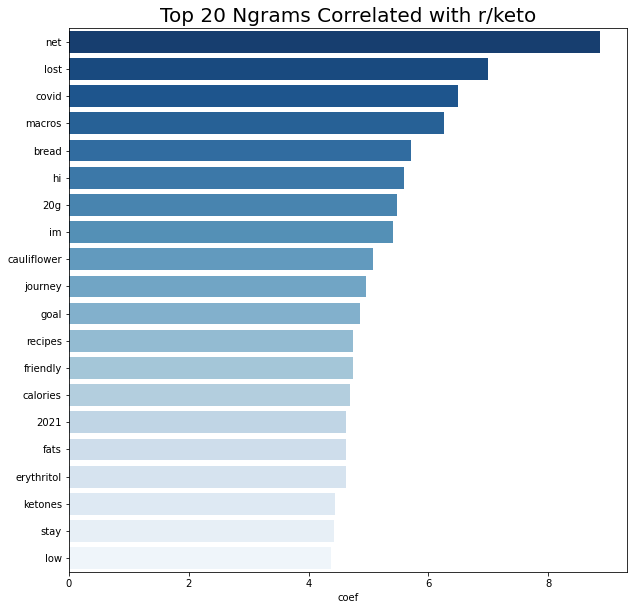

In [502]:
# creating chart of top 20 words
plt.figure(figsize=(10,10))
sns.barplot(data=top_keto_coefs, x=-top_keto_coefs['coef'], y='ngram', palette='Blues_r')
plt.ylabel('')
plt.title('Top 20 Ngrams Correlated with r/keto', fontsize=20);

From the above two charts, we can see that the top words associated with our best model for `r/keto` mentions very few food items, and more of diet terminologies, e.g. 'Macros', 'goal', 'weight'. Surprisingly, it seems that covid was mentioned many times, which might be because of concerns with whether the Keto diet will interfere with covid immunity.

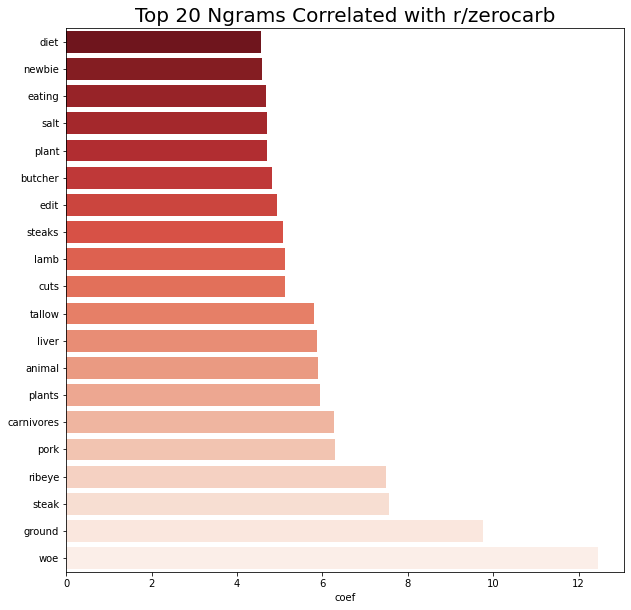

In [503]:
# creating chart of top 20 words
plt.figure(figsize=(10,10))
sns.barplot(data=top_zerocarb_coefs, x=top_zerocarb_coefs['coef'], y='ngram', palette='Reds_r')
plt.ylabel('')
plt.title('Top 20 Ngrams Correlated with r/zerocarb', fontsize=20);

From the above chart, we can see that the top words associated with our best model for `r/keto` mentions no diet terminologies, and is mainly made up of words for meat items, e.g. 'steaks', 'lamb', 'pork'. Surprisingly, there is a word called `woe`, mentioned many times. Upon some research, we found out that `woe` is actually referring to 'way of eating' and it is commonly used among those individuals who follow a 'carnivore' diet. As such, we will remove this word, and rerun our baseline model, and our latest model.

# Rerun Modeling

In [504]:
# adding 'woe' to stop words
custom_stop_words += ['woe']

In [419]:
# creating pipeline for baseline model
pipe_baseline = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=custom_stop_words)),
    ('nb', MultinomialNB())]
)

pipe_baseline.fit(X_train, y_train)

pipe_baseline.score(X_test, y_test)

0.8136756481952212

In [420]:
bm_predictions = pipe_baseline.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, bm_predictions).ravel()

print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')

True Negatives: 1747
False Positives: 226
False Negatives: 507
True Positives: 1454


In [428]:
display(accuracy_score(y_test, bm_predictions))
display(precision_score(y_test, bm_predictions))

0.8136756481952212

0.8654761904761905

Our initial baseline score was **82.7%**, now our baseline score is **81.3%**. In the interest of time we will attempt to retune our `LogisticRegression` model, with `TfidfVectorizer` and attempt to get a better `accuracy` and `precision` score.

### Retune of LogReg model

In [424]:
lr_params_V6 = {
    # Trying different types of regularization
    'lr__penalty':['l2'],

     # Trying different C of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[5, 6, 7, 8, 9, 10, 11, 12]
}

tvec_lr_params_V6 = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[2, 3, 4],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.2, 0.25, 0.3, 0.35],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1, 2)]
}

In [425]:
tvec_lr_gs_V6 = get_model_scores_V2('tvec_lr_gs_V6', 
                              'tvec', 
                              'lr', 
                              vec_params=tvec_lr_params_V6, 
                              mod_params=lr_params_V6, 
                              grid_search=True)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
BEST PARAMS-->


{'lr__C': 6,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_lr_gs_V6',
 'model': 'lr',
 'vectorizer': 'tvec',
 'train_score': 0.9897044804575786,
 'test_score': 0.8403660396542959,
 'recall': 0.818969913309536,
 'true_neg_rate': 0.8616320324379118,
 'precision': 0.854709952102182,
 'is_tuned': True}

True Negatives: 1700
False Positives: 273
False Negatives: 355
True Positives: 1606


We can see that our `LogisticRegression` model, with `TfidfVectorizer`, is performing better than our baseline model, with accuracy at **84%** better by **1.3%**. Our `precision` score has deproved slightly by **1%**. Let's see if we can tune this more.

In [432]:
lr_params_V7 = {
    # Trying different types of regularization
    'lr__penalty':['l2'],

     # Trying different C of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[5.5, 6, 6.5]
}

tvec_lr_params_V7 = {
    # Setting a limit of n-number of features included
    'tvec__max_features': [None],
    
    # Setting a minimum number of times the 
    # word/token has to appear in n-documents
    'tvec__min_df':[1.5, 2, 2.5],
    
    # Setting an upper threshold/max percentage 
    # of n% of documents from corpus
    'tvec__max_df': [0.3,],
    
    # Testing with ngrams
    'tvec__ngram_range':[(1, 1), (1, 2), (1, 3)]
}

In [433]:
tvec_lr_gs_V7 = get_model_scores_V2('tvec_lr_gs_V7', 
                              'tvec', 
                              'lr', 
                              vec_params=tvec_lr_params_V7, 
                              mod_params=lr_params_V7, 
                              grid_search=True)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_tra

BEST PARAMS-->


{'lr__C': 6,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

METRICS-->


{'model_name': 'tvec_lr_gs_V7',
 'model': 'lr',
 'vectorizer': 'tvec',
 'train_score': 0.9897044804575786,
 'test_score': 0.8403660396542959,
 'recall': 0.818969913309536,
 'true_neg_rate': 0.8616320324379118,
 'precision': 0.854709952102182,
 'is_tuned': True}

True Negatives: 1700
False Positives: 273
False Negatives: 355
True Positives: 1606


We believe that we have pushed this model as far as it can go in terms of balance between `accuracy` and `precision`.
In the interest of time, we will stick to `LogisticRegression` with `TfidfVectorizer` model V6, or model V7. Let's review the results between the different models.

---

In [538]:
model_scoresV2 = pd.DataFrame(model_eval)
model_scoresV2.drop(columns=['train_score', 'recall', 'true_neg_rate'])\
.tail(2).sort_values(by=['precision', 'test_score'], ascending=False).head()

,model_name,model,vectorizer,test_score,precision,is_tuned
17,tvec_lr_gs_V6,lr,tvec,0.840366,0.85471,True
18,tvec_lr_gs_V7,lr,tvec,0.840366,0.85471,True


In [573]:
model_scoresV2.loc[[17, 18, 19], ['model_name','model','vectorizer','test_score','precision','is_tuned']]

,model_name,model,vectorizer,test_score,precision,is_tuned
17,tvec_lr_gs_V6,lr,tvec,0.840366,0.85471,True
18,tvec_lr_gs_V7,lr,tvec,0.840366,0.85471,True
19,baseline_model,nb,tvec,0.813670,0.86547,False


In [564]:
# saving our custom stop words with 'woe'
custom_stop_words = pd.DataFrame(custom_stop_words, columns=['words'])
custom_stop_words.to_csv('datasets/custom_stop_words.csv', index=False)

Based on the above model, it seems that the model that performs the best is the following model:
`LogisticRegression` with `TfidfVectorizer` with the following parameters:<br>

**LogisticRegression**
- Penalty Type: `l2`
- Inverse Regularization Strength of `6` (`C`)

**TfidfVectorizer**
- `max_features`: None
- `max_df` of `0.3`
- `min_df` of `2`
- `ngram_range` of `(1, 2)`

### Top Words

Now we will take a look at which were the top words our model used as a predictor of the classification.

In [576]:
coefs = pd.DataFrame(tvec_lr_gs_V6.best_estimator_.steps[1][1].coef_.T, columns=['coef'])
coefs['ngram'] = tvec_lr_gs_V6.best_estimator_.steps[0][1].get_feature_names_out()
top_keto_coefs = coefs.sort_values('coef', ascending=True).head(20)
top_zerocarb_coefs = coefs.sort_values('coef', ascending=True).tail(20)

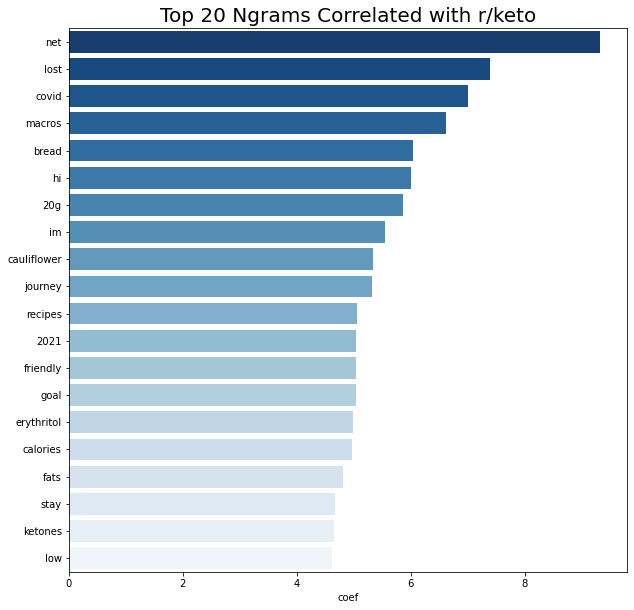

In [577]:
plt.figure(figsize=(10,10))
sns.barplot(data=top_keto_coefs, x=-top_keto_coefs['coef'], y='ngram', palette='Blues_r')
# plt.xticks(np.arange(0, 6, step=1))
plt.ylabel('')
plt.title('Top 20 Ngrams Correlated with r/keto', fontsize=20);

From the above charts, we can see that the top words associated with our best model for `r/keto` mentions very few food items, and more of diet terminologies, e.g. 'Macros', 'goal', 'weight'. Surprisingly, it seems that covid was mentioned many times, which might be because of concerns with whether the Keto diet will interfere with covid immunity.

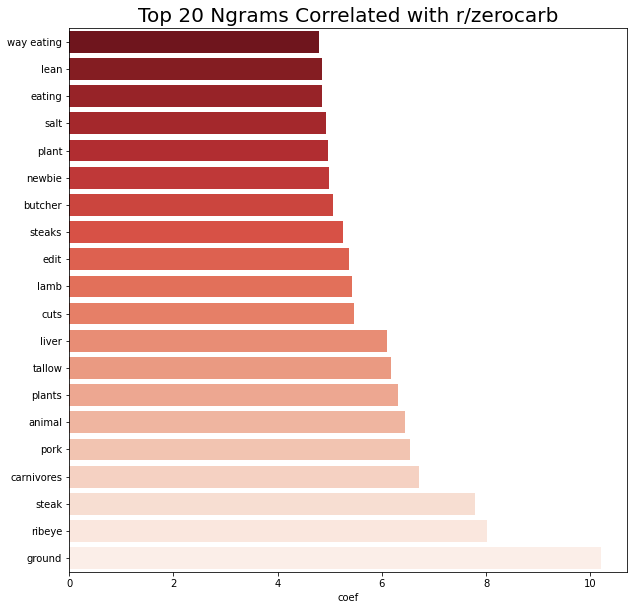

In [578]:
plt.figure(figsize=(10,10))
sns.barplot(data=top_zerocarb_coefs, x=top_zerocarb_coefs['coef'], y='ngram', palette='Reds_r')
plt.ylabel('')
plt.title('Top 20 Ngrams Correlated with r/zerocarb', fontsize=20);

After removing the word 'woe', we can see that the rest of our observations from earlier hold true. Those observations are:

From the above chart, we can see that the top words associated with our best model for `r/keto` mentions no diet terminologies, and is mainly made up of words for meat items, e.g. 'ground', 'steaks', 'lamb', 'pork'. A reason why '30 days' is on the list here, is because a social media influencer, ['Dr. Shawn Baker', encouraged people to do a 30 Day Carnivore diet challenge in April of 2020.](https://twitter.com/sbakermd/status/1243546540829859840?lang=en)

---

## Error Analysis

Let's create a DataFrame to look closer at the posts that were misclassified.

In [519]:
# creation of dataframe with probabilities as well as predictions vs actual

class_prob = pd.DataFrame(tvec_lr_gs_V6.predict_proba(X_test),
                          columns=['r/keto', 'r/zerocarb'])

class_prob['c_text'] = X_test.tolist()
class_prob['is_zerocarb'] = y_test.tolist()
class_prob['predicted'] = tvec_lr_gs_V6.predict(X_test)
class_prob.isnull().sum()

r/keto         0
r/zerocarb     0
c_text         0
is_zerocarb    0
predicted      0
dtype: int64

In [520]:
# separating the two DataFrames, 1 for keto and 1 for zerocarb
misclass_zerocarb = class_prob[(class_prob['is_zerocarb'] == 1) & ((class_prob['predicted'] == 0))]
misclass_keto = class_prob[(class_prob['is_zerocarb'] == 0) & ((class_prob['predicted'] == 1))]

In [531]:
class_prob.sort_values('r/zerocarb', ascending=False).head(10)

,r/keto,r/zerocarb,c_text,is_zerocarb,predicted
2173,0.000019,0.999981,can you think of something animal based zc fri...,1,1
1796,0.000111,0.999889,tldr does anyone have an intolerance to ground...,1,1
3892,0.000113,0.999887,6 days ago i posted about issues of frequentin...,1,1
896,0.000283,0.999717,i have decided that lamb is the superior anima...,1,1
419,0.000354,0.999646,been eating ground beef ground pork bacon and ...,1,1
3318,0.000373,0.999627,hi all i have a question i'm dying to hear if ...,1,1
3824,0.000446,0.999554,to make the life easier for people feel free t...,1,1
1250,0.000606,0.999394,i found a farmer not too far away from where i...,1,1
2603,0.000616,0.999384,my source of ground beef is very lean probably...,1,1
998,0.000635,0.999365,i've upped my ribeye intake to 3lb a day and m...,1,1


In [532]:
misclass_keto.sort_values('r/zerocarb', ascending=False).head(10)

,r/keto,r/zerocarb,c_text,is_zerocarb,predicted
2230,0.002844,0.997156,so tomorrow i am making my first ever bone bro...,0,1
1736,0.011134,0.988866,i've started eating canned cod liver every tim...,0,1
3450,0.015851,0.984149,so i am looking to start keto and i know i wan...,0,1
3743,0.022497,0.977503,so does it matter if it is from a cow a goat a...,0,1
71,0.023091,0.976909,hey pals i love steak but like every single ri...,0,1
2169,0.026650,0.973350,tips with the cuts would fit into the lean cat...,0,1
2427,0.046326,0.953674,i cant eat any sort of dairy it gives me sever...,0,1
2498,0.052120,0.947880,that would be hyperbole on anybody else but i'...,0,1
3758,0.052252,0.947748,for my whole life i have been trained to think...,0,1
670,0.053211,0.946789,i am both omad and keto the omad community is ...,0,1


In [534]:
# code to cycle through the index of False Positives
misclass_keto.loc[670, 'c_text']

"i am both omad and keto the omad community is freaked the fuck out by what i eat usually people are freaked out by omad itself but i can freak out the people that freak other people out so here is my meal today  i am doing an experiment to see the reaction of each of these subreddits that is one big ass steak and 4 eggs covered in grass fed butter bacon a chunk of aged cheese and sardines i am stuffed and happy i don't really know the calories or the macros i know its a ton of fat and protein and most of that fat is saturated although i cooked the eggs in evoo as far as i am concerned this is the one of the healthiest meals i can eat but go ahead and criticize i am curious tasty keto meal"

---

From the above table, we can see that the model does have a pretty good grasp on posts talking about meats, ribeyes, ground beef, lean, animal organs, bones etc.

The posts that use this kind of language, invariably get classified as `r/zerocarb` sometimes wrongly. Other topics that will get classified as `r/zerocarb` are: Mentions newbie, discussing butchers in different areas, fatty food, and the [30 day challenge by Dr. Shawn Baker.](https://twitter.com/sbakermd/status/1243546540829859840?lang=en)

In [536]:
class_prob.sort_values('r/keto', ascending=False).head(10)

,r/keto,r/zerocarb,c_text,is_zerocarb,predicted
3205,0.999774,0.000226,hello keto friends i have done dirty keto in t...,0,0
2956,0.999643,0.000357,currently doing 1268 calories 33 deficit fat 8...,0,0
1776,0.999509,0.000491,hello friends tldr keto is going well but i ne...,0,0
1457,0.999453,0.000547,hi yall long time lurker but thanks to this th...,0,0
3609,0.999295,0.000705,10 years ago i was 5'6 and 240 lbs then i had ...,0,0
3246,0.999251,0.000749,hello all alfie isn't my name and keto is beco...,0,0
2563,0.999076,0.000924,start weight 309lb current weight 297 time on ...,0,0
1041,0.998848,0.001152,started keto 3 weeks ago at 307 and i'm down t...,0,0
159,0.998815,0.001185,first time poster and im looking for some sugg...,0,0
1880,0.998776,0.001224,i went all in on my weight loss last october a...,0,0


In [525]:
# code to cycle through the index of False Positives
misclass_zerocarb.sort_values('r/keto', ascending=False).head(10)

,r/keto,r/zerocarb,c_text,is_zerocarb,predicted
2525,0.982741,0.017259,have been on lowcarb keto for over a year lost...,1,0
576,0.979756,0.020244,i am 278 as of today iv already lost 40ish lbs...,1,0
957,0.977588,0.022412,i have a bmi of 175 i currently want to cut on...,1,0
3244,0.977143,0.022857,will it hurt my exercise performance its 228g ...,1,0
78,0.976533,0.023467,hey all i was playing around with data from th...,1,0
2419,0.966528,0.033472,back story i have pvc caused by an electrical ...,1,0
3203,0.956542,0.043458,ive been low to no carb now since late aprilea...,1,0
2242,0.956153,0.043847,been tracking what i eat for 3 weeks and aimin...,1,0
3216,0.949903,0.050097,all right guys i dont know where else to ask y...,1,0
3763,0.949748,0.050252,just went to the doctor to get some blood work...,1,0


In [527]:
# code to cycle through the index of False Positives
misclass_zerocarb.loc[3216, 'c_text']

'all right guys i dont know where else to ask you should know about this basically im staring a bulk soon and i dont want to stay zerocarb for that time should i just go full on high carb with rice and shit ton of pasta or stay mostly zero carb but still a decent amount of carbs in form of peanut butter protein shakesbars and some fruitsveggies and a bit of grain is it worth staying mostly meat if youre not fully zero carb'

---

From the above table, we can see that the model does have a pretty good grasp on posts talking about meats, ribeyes, ground beef, lean, animal organs, bones etc.

The posts that use this kind of language, invariably get classified as `r/zerocarb` sometimes wrongly. Other topics that will get classified as `r/zerocarb` are: Mentions newbie, discussing butchers in different areas, fatty food, and the [30 day challenge by Dr. Shawn Baker.](https://twitter.com/sbakermd/status/1243546540829859840?lang=en)

# Model Limitations

Let us start by recapping our problem statement:

## Problem Statement

We are concerned that misclassification of clients into certain diet models will result in a rebound that deproves their health and fitness, also affecting motivation to get back into shape in the future. This is especially the case for highly motivated individuals, who go hard into pursuing a 'Zerocarb/Carnivore' diet, and crash or rebound after. The effects of the rebound can lead to worse weight gain, to the point the individual is unhealthier than when they started.

So the goal of the model is to reduce False Positives, i.e. classifying clients into `zerocarb` wrongly when they should have been in the `keto` class.

## Conclusion

As shown by the tables and charts above, our model is able to grasp mentions of 'bone broth', 'meat', 'ground beef' and other similar words. Mentions of improved health, e.d. reduced blood pressure also end up classified as `zerocarb`.

However our model is thrown off by mentions of animal organs and the word bone specifically. The context of the words can be different, and they might be relevant to both `keto` and `zerocarb`, however as long as the post contains these words, it will most likely be classfied as `zerocarb`. 

Even though both `r/keto` and `r/zerocarb` are both very similar in the sense that they are both proponents of high protein, high fat, and low/no carb diets and lifestyle, the `r/zerocarb` definitely has a much larger focus on meat(especially beef), animal organs, and bones (bone broth).

### Model Improvements and Recommendations

**Improvements**
It is in our interest to reduce False Positives as much as possible, as such, we would prefer to maximize the `precision` score of the model as much as possible.<br>
1. One way we can do this is test other models such as support vector machines, and perhaps deep learning models as well.
2. Another way we can do this is to adjust the threshold for the classification of `zerocarb`, making this an imbalanced classification. This will require further investigation as we continue to improve the model. <br>
3. Lastly, we can include other features in our model, other than just text, sentiment analysis for example, could possible improve the classification score.

**Recommendations**
1. Our current model performs 2% better than our baseline model on accuracy. As such we would reccommend using this model for classification. 
2. For those model probabilities where the classification is boderline, e.g. 51% vs 49%, we would recommend classifiying those as `keto`, as it is easier to make the jump from `keto` to `zerocarb` if the client still wants to do so.
3. Lastly, we would also recommend reviewing those clients within one month of being put on the `zerocarb` diet. If we review them within one month and find that the diet is not working, it might not be too late to move them to `keto` diets and prevent a rebound from happening.